In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl

In [3]:
df = pd.read_csv("./mnist_784.csv")
df.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,class
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9


In [4]:
df_4 = df[df["class"] == 4].drop(["class"], axis = 1)[:5]
n = df_4.values.sum(axis = 1)
A = (df_4.values.T / n).T.reshape(len(df_4), 28, 28)

In [5]:
element_max = np.vectorize(max)
def sinkhorn(C, a, b, epsilon, precision, max_iters: int = 100, verbose: bool = False):
    a = a.reshape((C.shape[0], 1))
    b = b.reshape((C.shape[1], 1))
    K = np.exp(-C/epsilon)
    
    # initialization
    u = np.ones((C.shape[0], 1))
    v = np.ones((C.shape[1], 1))
    P = np.diag(u.flatten()) @ K @ np.diag(v.flatten())
    p_norm = np.trace(P.T @ P)
    
    iters = 0
    while True:
        u = a/element_max((K @ v), 1e-300) # avoid divided by zero
        v = b/element_max((K.T @ u), 1e-300)
        P = np.diag(u.flatten()) @ K @ np.diag(v.flatten())
        err = abs((np.trace(P.T @ P) - p_norm)/p_norm)
        if err < precision or iters >= max_iters:
            break
        p_norm = np.trace(P.T @ P)
        iters += 1
        if verbose:
            print(f"{iters}/{err}")
    return P, np.trace(C.T @ P)

In [6]:
from scipy.spatial import distance_matrix

In [7]:
element_max = np.vectorize(max)

def barycenter(bs, epsilon, precision, max_iters: int = 100, verbose: bool = False):
    
    s, n = bs.shape[0], bs.shape[1]
    weights = np.ones(s) / s
    
    a = (np.ones(n) / n).reshape((n, 1))
    bs = bs.reshape((s, n, 1))
    
    def create_cost_matrix():
        t = np.linspace(0, 1, n)
        Y, X = np.meshgrid(t, t)
        return (X - Y)**2
    
    C = create_cost_matrix()
    K = np.exp(-C / epsilon)
    
    us = np.ones((s, n, 1))
    vs = np.ones((s, n, 1))
    
    def get_joint_distribution():
        Ps = []
        for i in range(s):
            P = np.diag(us[i].flatten()) @ K @ np.diag(vs[i].flatten())
            Ps.append(P)
        return np.concatenate(Ps).reshape(s, n, n)
    
    def get_loss_value():
        return sum([np.trace(C.T @ Ps[i]) for i in range(s)])
            
    
    Ps = get_joint_distribution()
    loss = get_loss_value()
    
    def update_vs():
        for i in range(s):
            vs[i] = bs[i]/element_max(K.T @ us[i], 1e-300)
            
    def update_a():
        new_a = (np.ones(n) / n).reshape((n, 1))
        for i in range(s):
            new_a *= (K @ vs[i])**weights[i]
        return new_a
    
    def update_us():
        for i in range(s):
            us[i] = a/element_max(K @ vs[i], 1e-300)
    
    iters = 0
    while True:
        update_vs()
        a = update_a()
        update_us()
        Ps = get_joint_distribution()
        err = abs((get_loss_value() - loss)/loss)
        if err < precision or iters >= max_iters:
            break
        loss = get_loss_value()
        iters += 1
        if verbose:
            print(f"{iters}/{err}")
    
    return a, get_joint_distribution(), get_loss_value()

In [8]:
A.shape

(5, 28, 28)

In [9]:
Bs = A.reshape(A.shape[0], A.shape[1]*A.shape[2])

In [10]:
Bs.shape

(5, 784)

In [11]:
a, ps, loss = barycenter(Bs, 0.09, 1e-15, 1000, verbose = True)

1/0.9999999951332468
2/784.0731167724641
3/0.00027546119248578763
4/8.160826837827958e-05
5/2.5584632221197263e-05
6/8.164265717595107e-06
7/2.621762782156317e-06
8/8.44370098383713e-07
9/2.7246312578540415e-07
10/8.806607023283189e-08
11/2.8511756015258302e-08
12/9.246393905560186e-09
13/3.003870698423427e-09
14/9.776416745901782e-10
15/3.1878363125642154e-10
16/1.0414939971508623e-10
17/3.4094584282427875e-11
18/1.1184321381636381e-11
19/3.676623837872201e-12
20/1.2111020588834894e-12
21/3.997174530794638e-13
22/1.323429235531627e-13
23/4.391514619032131e-14
24/1.4638382063439795e-14
25/4.6305086119043566e-15
26/1.6430837009983125e-15


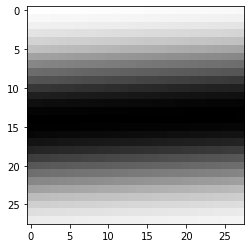

In [12]:
plt.imshow(a.reshape(28, 28), cmap = mpl.colormaps["Greys"])

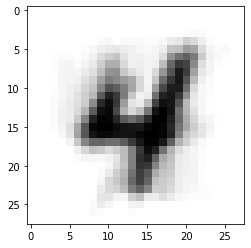

In [11]:
plt.imshow(a.reshape(28, 28), cmap = mpl.colormaps["Greys"])

In [13]:
from ot.bregman import barycenter_sinkhorn

In [15]:
A.shape

(5, 28, 28)

In [16]:
a = A.reshape(A.shape[0], A.shape[1]*A.shape[2])

In [40]:
a.T.shape

(784, 5)

In [37]:
def create_cost_matrix():
    t = np.linspace(0, 1, 784)
    Y, X = np.meshgrid(t, t)
    return (X - Y)**2

In [38]:
c = create_cost_matrix()

In [39]:
c.shape

(784, 784)

In [41]:
b = barycenter_sinkhorn(a.T, c, reg = 0.001)

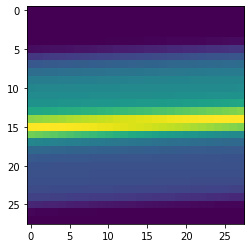

In [43]:
plt.imshow(b.reshape(28, 28))

In [53]:
P, W = sinkhorn(C, p_a, p_b, epsilon = 1, precision = 1e-30)

In [56]:
P.shape # (n_bins, n_bins)

(5, 5)

In [65]:
P.sum(axis=0)

array([675.,  16.,  12.,  18.,  63.])

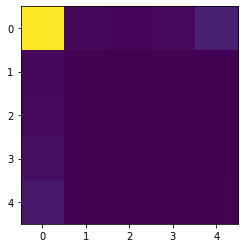

In [59]:
plt.imshow(P)

In [67]:
a = np.array([[1,2,3],[4,5,6]])
b = np.array([1,2,3])

In [68]:
np.dot(a, b)

array([14, 32])

## Перенос цветовой гаммы между изображениями

In [4]:
from ot.utils import list_to_array
import matplotlib.image as mpimg
from ot.da import SinkhornTransport

In [5]:
def im2mat(img):
    """Converts an image to matrix (one pixel per line)"""
    return img.reshape((img.shape[0] * img.shape[1], img.shape[2]))

def minmax(img):
    return np.clip(img, 0, 1)

def mat2im(X, shape):
    """Converts back a matrix to an image"""
    return X.reshape(shape)

In [6]:
src_img = plt.imread("plant1.jpg") / 256
trg_img = plt.imread("plant2.jpg") / 256

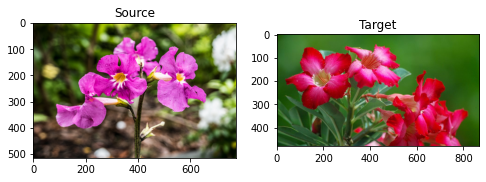

In [7]:
fig, axes = plt.subplots(1, 2, figsize = (8, 8))
axes[0].imshow(src_img)
axes[0].set_title("Source")
axes[1].imshow(trg_img)
axes[1].set_title("Target")

plt.show()

In [8]:
X1 = im2mat(src_img)
X2 = im2mat(trg_img)

rng = np.random.RandomState(42)

# training samples
nb = 2000
idx1 = rng.randint(X1.shape[0], size=(nb,))
idx2 = rng.randint(X2.shape[0], size=(nb,))

Xs = X1[idx1, :]
Xt = X2[idx2, :]

In [9]:
from scipy.spatial import distance_matrix

In [42]:
cost = distance_matrix(Xs, Xt)**2

In [43]:
src_dist = np.array([1] * len(Xs)) / len(Xs)
trg_dist = np.array([1] * len(Xt)) / len(Xt)

In [62]:
P, W = sinkhorn(cost, src_dist, trg_dist, epsilon = 1e-2, precision = 1e-9, max_iters = 1000, verbose = True)

1/0.9999999990202832
2/0.4944236298189533
3/0.3470567859358436
4/0.20208869519186085
5/0.12823253166870827
6/0.09680993269020063
7/0.07729923054342613
8/0.062149920506547336
9/0.04862238897872468
10/0.036048269397434496
11/0.026167704013347396
12/0.018801336061497535
13/0.013381175809461463
14/0.00961532259543689
15/0.00715130627614543
16/0.005610373299715351
17/0.004676148362171405
18/0.004108098510275491
19/0.0037243100535950795
20/0.003386440487480873
21/0.0029965040129072045
22/0.0025048260971396326
23/0.0019170317557844136
24/0.0012842356783182103
25/0.0006763291608850985
26/0.00015423501202984637
27/0.00024598609379579336
28/0.0005156168615616381
29/0.0006669979407740174
30/0.0007240801140580321
31/0.0007140292553856708
32/0.0006618091483518025
33/0.0005876858755099473
34/0.0005066884694177172
35/0.0004290851084981537
36/0.00036128914233348147
37/0.00030687098007980507
38/0.00026746552054741907
39/0.0002434422945921038
40/0.000234307628373887
41/0.00023890443178680966
42/0.000255

318/4.620179897408749e-07
319/4.494906978309519e-07
320/4.373027413506168e-07
321/4.254449463233493e-07
322/4.139083867715856e-07
323/4.02684374601706e-07
324/3.9176445858971893e-07
325/3.8114041305319743e-07
326/3.708042354216572e-07
327/3.607481383467797e-07
328/3.509645452507499e-07
329/3.4144608162783226e-07
330/3.3218557463763814e-07
331/3.2317604400248695e-07
332/3.1441069614061907e-07
333/3.0588292375980623e-07
334/2.975862955416509e-07
335/2.8951455452200227e-07
336/2.816616130335041e-07
337/2.7402154764823184e-07
338/2.665885941204149e-07
339/2.593571455649588e-07
340/2.5232174456906527e-07
341/2.454770825842957e-07
342/2.3881799385842283e-07
343/2.3233945260306647e-07
344/2.260365689479943e-07
345/2.1990458449101606e-07
346/2.139388694657901e-07
347/2.081349211230725e-07
348/2.0248835604505045e-07
349/1.969949101445443e-07
350/1.916504356307686e-07
351/1.8645089595281486e-07
352/1.8139236357442247e-07
353/1.7647101774878523e-07
354/1.716831406755373e-07
355/1.6702511628678683

In [33]:
sin = SinkhornTransport(reg_e=1e-2)
sin.fit(Xs=Xs, Xt=Xt)

In [63]:
sin.coupling_.shape, P.shape

((2000, 2000), (2000, 2000))

In [70]:
P2 = P

In [81]:
P = P2

In [82]:
def transform(Xst, batch_size=128):
    if np.array_equal(Xs, Xst):
        transp = P / np.sum(P, axis=1)[:, None]
        transp[~ np.isfinite(transp)] = 0
        transp_Xs = np.dot(transp, Xs)
    else:
        indices = np.arange(Xst.shape[0])
        batch_ind = [
            indices[i:i + batch_size]
            for i in range(0, len(indices), batch_size)]

        transp_Xs = []
        for bi in batch_ind:
            # get the nearest neighbor in the source domain
            D0 = distance_matrix(Xst[bi], Xs)**2
            idx = np.argmin(D0, axis=1)

            transp = P / np.sum(P, axis=1)[:, None]
            transp[~ np.isfinite(transp)] = 0
            transp_Xs_ = np.dot(transp, Xt)

            # define the transported points
            transp_Xs_ = transp_Xs_[idx, :] + Xst[bi] - Xs[idx, :]

            transp_Xs.append(transp_Xs_)

        transp_Xs = np.concatenate(transp_Xs, axis=0)

    return transp_Xs

In [84]:
t1 = transform(X1)

In [56]:
t1.shape

(399125, 3)

In [57]:
X1.shape

(399125, 3)

In [85]:
tr_src = minmax(mat2im(t1, src_img.shape))

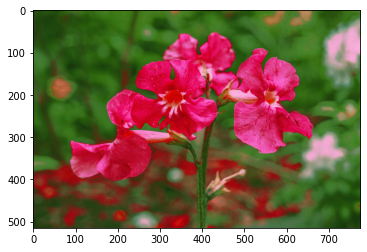

In [86]:
plt.imshow(tr_src)